In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [8]:
non_feature_columns = ['Ticker Symbol', 'Period Ending', 'Sector', 'For Year', 'Next Qtr. Avg. Price', 'Q avg to Q avg Price % Change', 'Y avg to Y avg Price % Change', 'Up or Down Q over Q', 'Up or Down Y over Y', 'Buy, Hold, or Sell']
less_useful_parameters = ["Add'l income/expense items", "Deferred Asset Charges", "Deferred Liability Charges", "Effect of Exchange Rate", "Minority Interest", "Misc. Stocks", "Non-Recurring Items", "Other Assets", "Other Current Assets", "Other Current Liabilities", "Other Equity", "Other Financing Activities", "Other Investing Activities", "Other Liabilities", "Other Operating Activities", "Other Operating Items"]
target_variable = 'Next Qtr. Avg. Price'

# Load the merged dataset
fundamentals = pd.read_csv('../data/merged_data.csv')

# Count the number of stocks in each sector
sector_counts = fundamentals['Sector'].value_counts()

# Display the counts of all sectors
print(sector_counts)


Sector
Consumer Discretionary         249
Industrials                    219
Information Technology         216
Health Care                    154
Energy                         114
Consumer Staples                99
Materials                       89
Utilities                       88
Real Estate                     28
Telecommunications Services     20
Financials                      19
Name: count, dtype: int64


Total no. of features: 59

Accounts Payable                                       0.041519
Accounts Receivable                                   -0.056108
After Tax ROE                                          0.009448
Capital Expenditures                                   0.029897
Capital Surplus                                       -0.074463
Cash Ratio                                             0.125669
Cash and Cash Equivalents                              0.011111
Changes in Inventories                                -0.071708
Common Stocks                                          0.001447
Cost of Revenue                                        0.016306
Current Ratio                                          0.102463
Depreciation                                          -0.039789
Earnings Before Interest and Tax                       0.034026
Earnings Before Tax                                    0.039223
Equity Earnings/Loss Unconsolidated Subsidiary         0.000167
Fixed Assets 

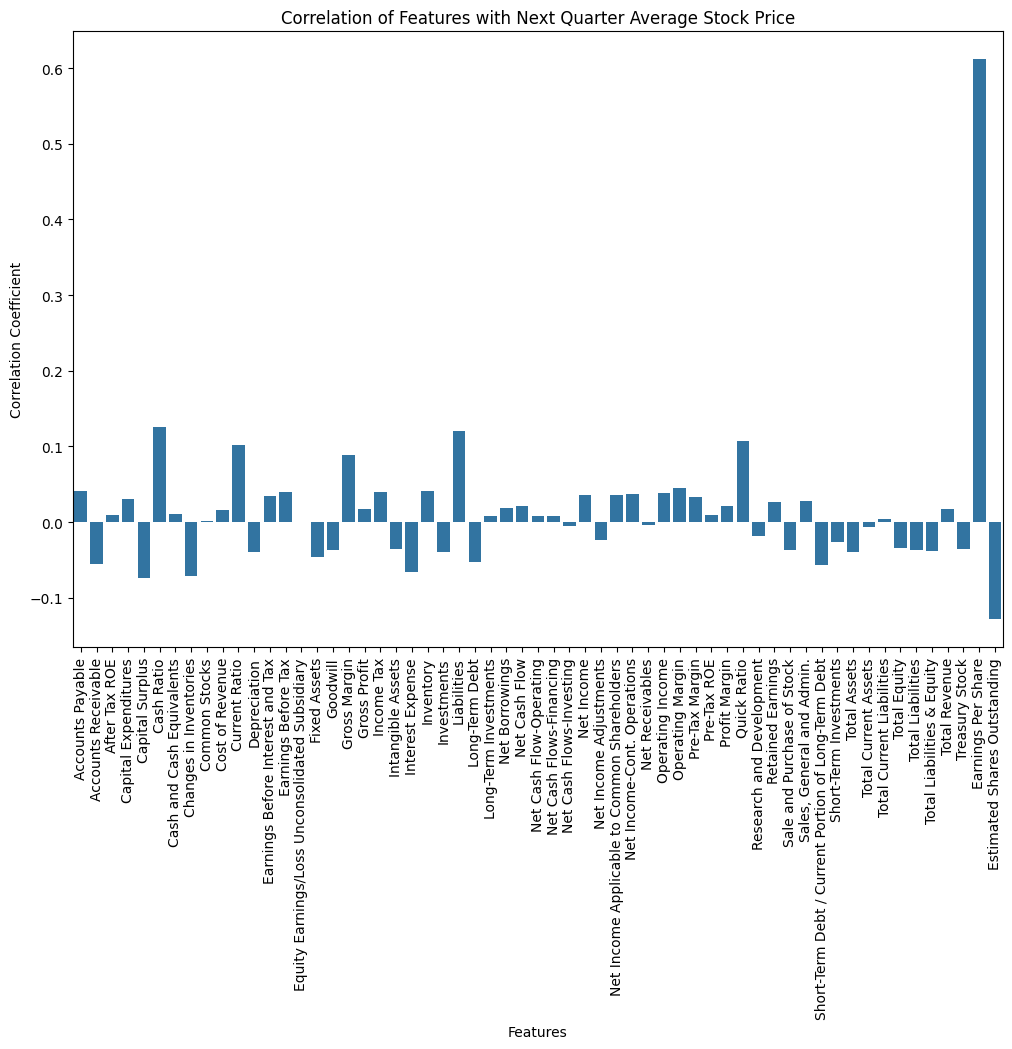

In [9]:
# Drop some columns which are redundant and less useful for fundamental analysis
fundamentals = fundamentals.drop(columns=less_useful_parameters)

# Check for NaN values in target variable and handle them
if fundamentals[target_variable].isna().sum() > 0:
    fundamentals[target_variable].fillna(method='bfill', inplace=True)

# Select features and target variable
features = fundamentals.drop(columns=non_feature_columns)
target = fundamentals[target_variable]

print(f'Total no. of features: {features.columns.size}\n')

# Combine features and target into a single DataFrame for correlation analysis
combined_data = pd.concat([features, target], axis=1)

# Calculate the correlation matrix
corr_matrix = combined_data.corr()

# Extract correlation of each feature with the target variable
target_corr = corr_matrix[target_variable].drop(target_variable)

# Display the correlation of each feature with the target variable
print(target_corr)

# Visualize the correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.xticks(rotation=90)
plt.title('Correlation of Features with Next Quarter Average Stock Price')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()


In [10]:
# Define LinearRegression model
model = LinearRegression()

# Initialize RFE to pick the top 30 out of the 59 features
rfe = RFE(estimator=model, n_features_to_select=30)

# Fit RFE
rfe.fit(features, target)

# Get the selected features
selected_features = features.columns[rfe.support_]

print(f'Selected Features:\n{selected_features}')

final_data = pd.DataFrame()
final_data['Ticker Symbol'] = fundamentals['Ticker Symbol']
final_data['Period Ending'] = fundamentals['Period Ending']
final_data[selected_features] = fundamentals[selected_features]
final_data[target_variable] = fundamentals[target_variable]

final_data.to_csv('../data/clean/lr_data.csv')

Selected Features:
Index(['Accounts Receivable', 'After Tax ROE', 'Cash Ratio',
       'Cash and Cash Equivalents', 'Changes in Inventories',
       'Cost of Revenue', 'Current Ratio', 'Depreciation',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Gross Margin', 'Gross Profit', 'Income Tax', 'Interest Expense',
       'Liabilities', 'Net Income',
       'Net Income Applicable to Common Shareholders', 'Operating Income',
       'Operating Margin', 'Pre-Tax Margin', 'Pre-Tax ROE', 'Profit Margin',
       'Quick Ratio', 'Research and Development', 'Short-Term Investments',
       'Total Equity', 'Total Liabilities', 'Total Liabilities & Equity',
       'Total Revenue', 'Earnings Per Share'],
      dtype='object')


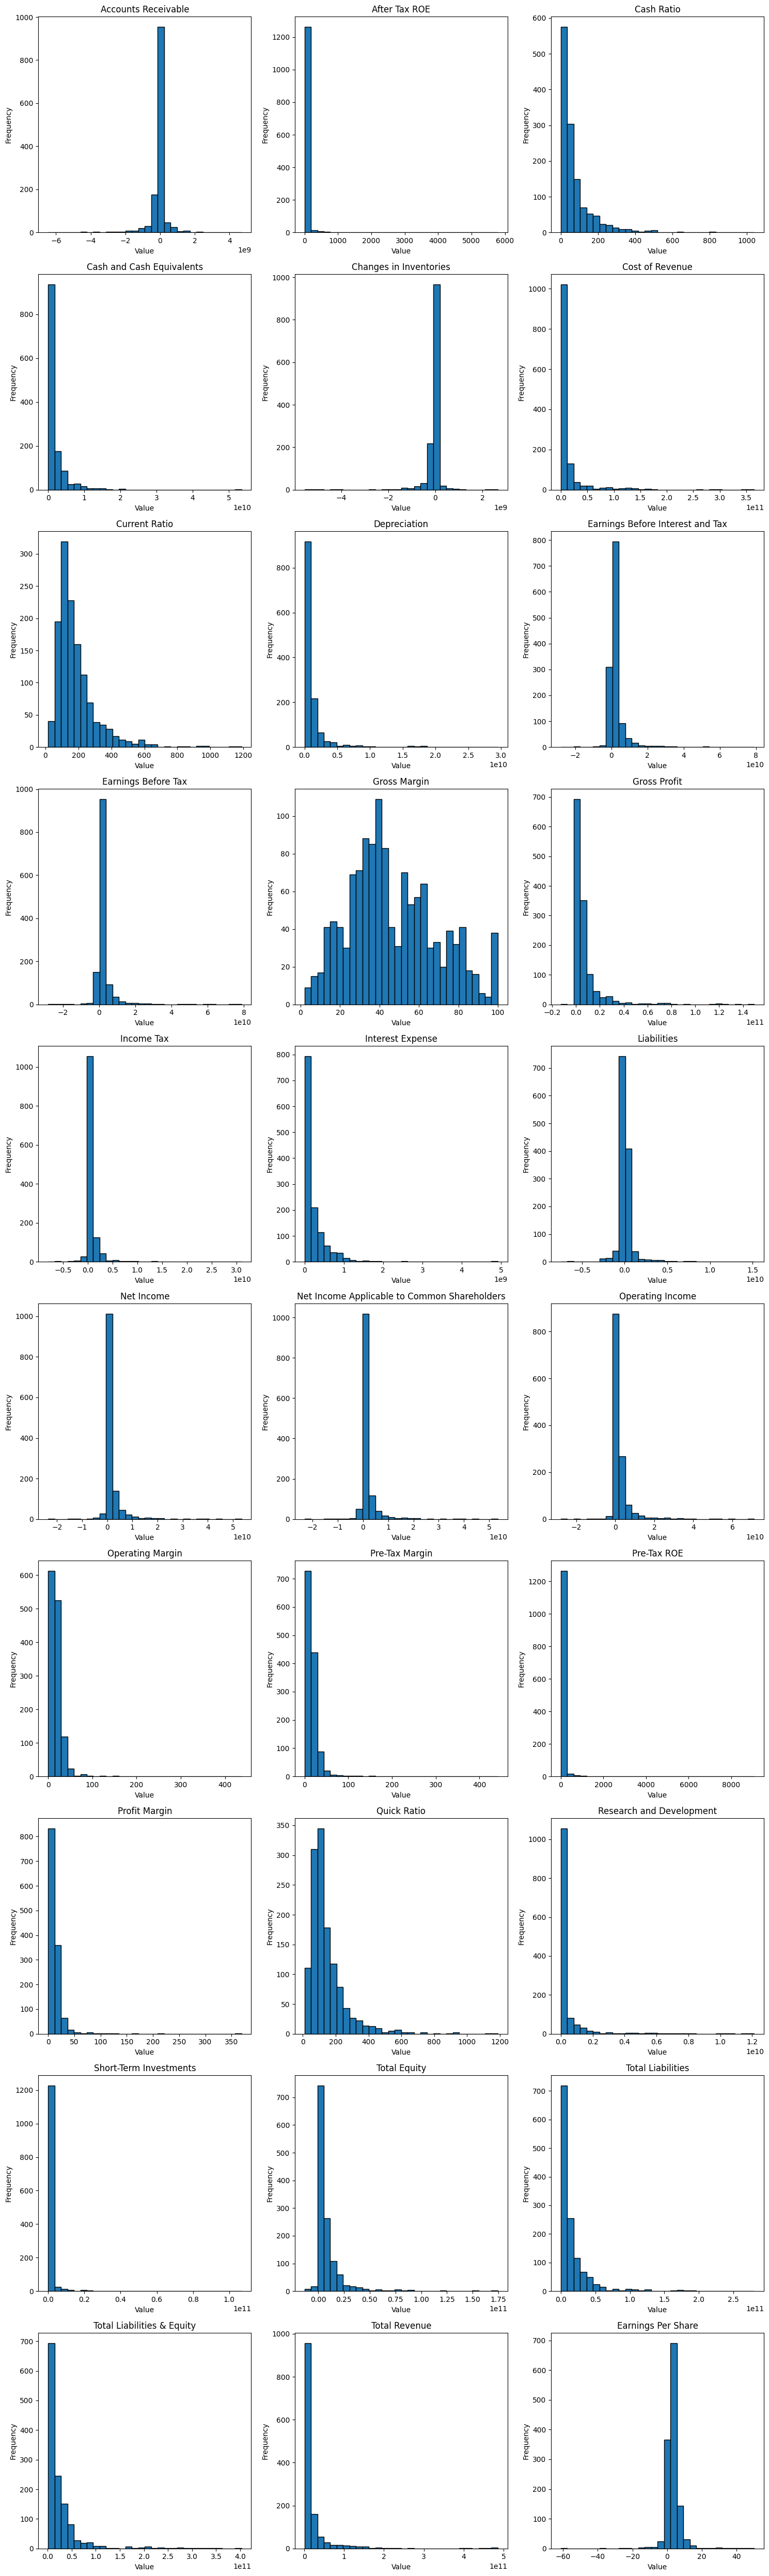

In [11]:
num_features = len(selected_features)

# Create a subplot grid
fig, axes = plt.subplots(nrows=num_features//3 + (num_features % 3 > 0), ncols=3, figsize=(15, 5*num_features//3 + (num_features % 3 > 0)))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    axes[i].hist(final_data[feature].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(feature)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


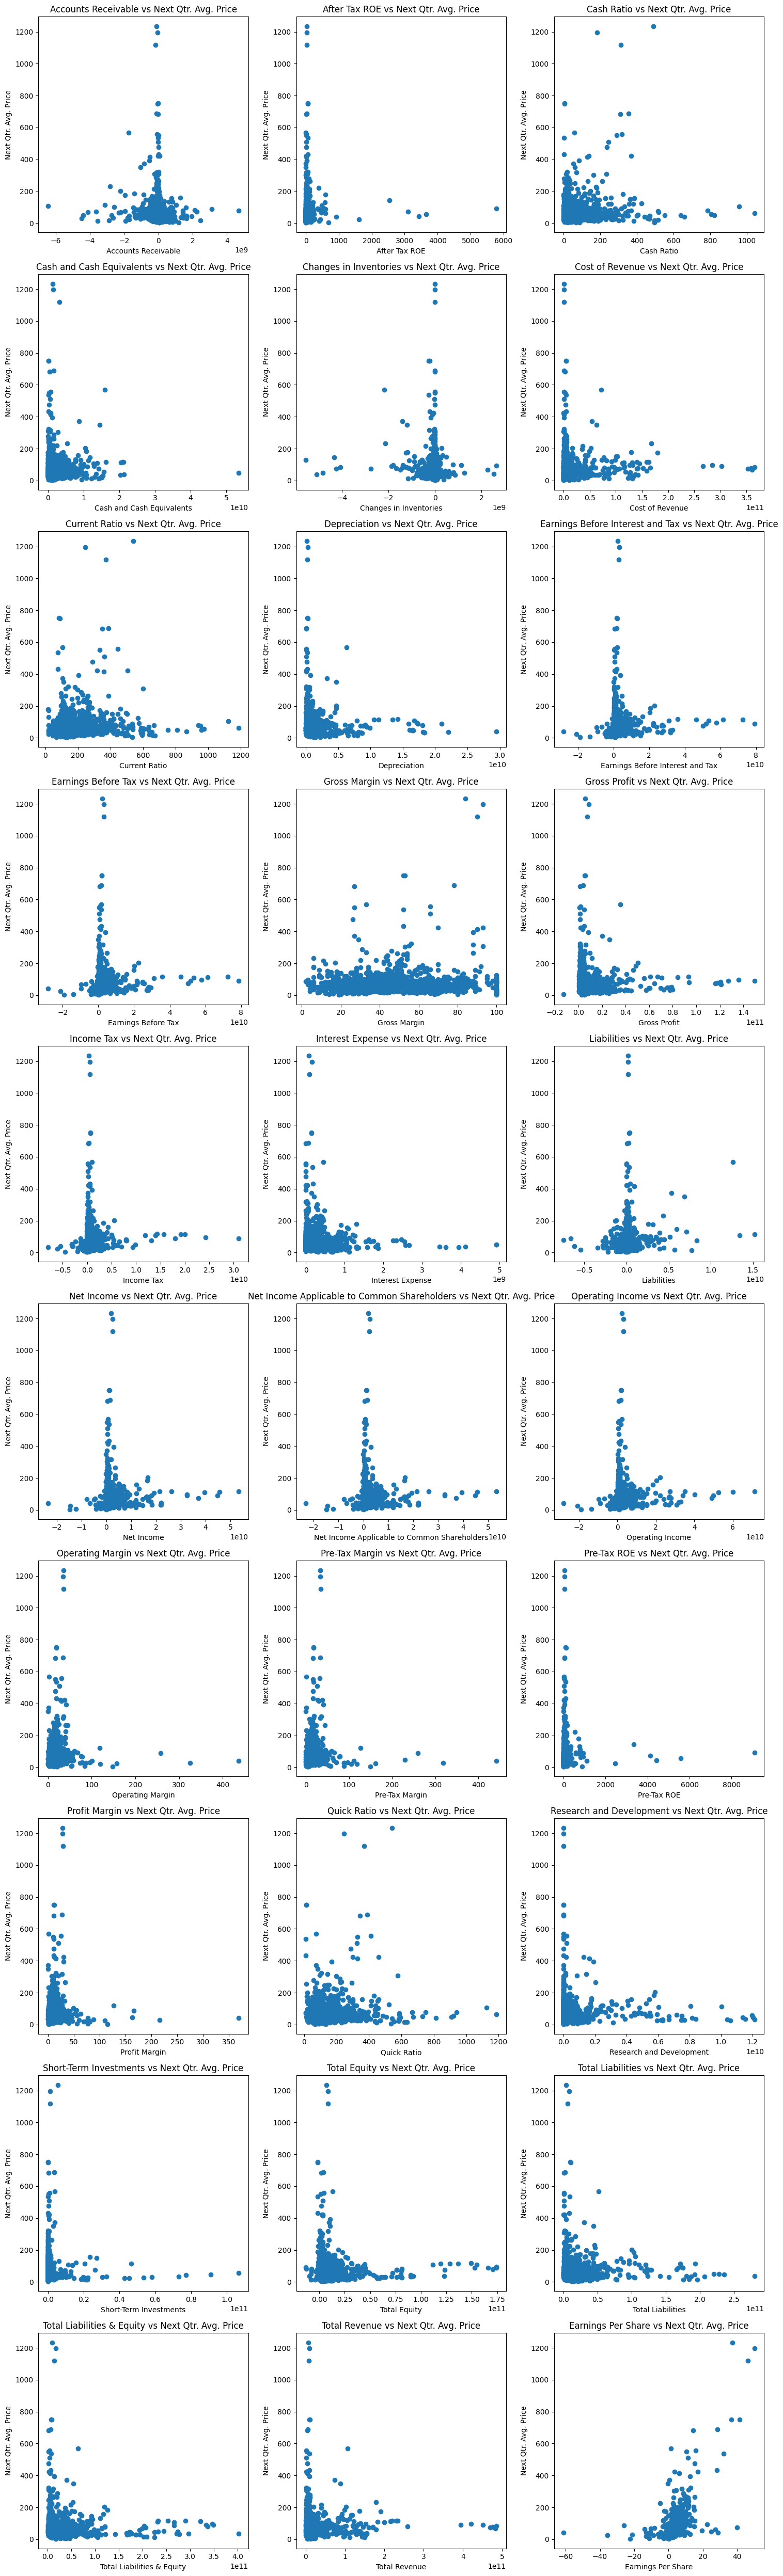

In [12]:
num_features = len(selected_features)

# Create a subplot grid
fig, axes = plt.subplots(nrows=num_features//3 + (num_features % 3 > 0), ncols=3, figsize=(15, 5*num_features//3 + (num_features % 3 > 0)))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    axes[i].scatter(final_data[feature], final_data[target_variable])
    axes[i].set_title(f'{feature} vs {target_variable}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_variable)

# Hide any unused subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
